# L3: Text clustering and topic modelling

Text clustering groups documents in such a way that documents within a group are more &lsquo;similar&rsquo; to other documents in the cluster than to documents not in the cluster. The exact definition of what &lsquo;similar&rsquo; means in this context varies across applications and clustering algorithms.

In this lab you will experiment with both hard and soft clustering techniques. More specifically, in the first part you will be using the $k$-means algorithm, and in the second part you will be using a topic model based on the Latent Dirichlet Allocation (LDA).

**A quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating)**

## Hard clustering data set

The raw data for the hard clustering part of this lab is a collection of product reviews. We have preprocessed the data by tokenization and lowercasing.

In [47]:
import pandas as pd
import bz2

with bz2.open('reviews.json.bz2') as source:
    df = pd.read_json(source)

When you inspect the data frame, you can see that there are three labelled columns: `category` (the product category), `sentiment` (whether the product review was classified as &lsquo;positive&rsquo; or &lsquo;negative&rsquo; towards the product), and `text` (the space-separated text of the review).

In [48]:
df.head()

,category,sentiment,text
0,music,neg,i bought this album because i loved the title ...
1,music,neg,i was misled and thought i was buying the enti...
2,books,neg,"i have introduced many of my ell , high school..."
3,books,pos,anything you purchase in the left behind serie...
4,dvd,pos,"i loved these movies , and i cant wiat for the..."


## Problem 1: K-means clustering

Your first task is to cluster the product review data using a tf–idf vectorizer and a $k$-means clusterer.

Start by doing the vectorization. In connection with vectorization, you should also filter out standard English stop words. While you could use [spaCy](https://spacy.io/) for this task, here it suffices to use the word list implemented in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [49]:
# TODO: Enter code here to vectorize the data and store it in a variable `reviews`
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize
vectorizer = TfidfVectorizer(stop_words='english')
reviews = vectorizer.fit_transform(df['text'])

Test your vectorization by running the following code cell:

In [50]:
reviews.shape

(11914, 46619)

If you used the English stop word list from scikit-learn, then the resulting vocabulary should have 46,619 entries.

Next, cluster the vectorized data. Before doing so, you should read the documentation of the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, which is scikit-learn&rsquo;s implementation of the $k$-means algorithm. As you can see, this class has several parameters that you can tweak. For now, the only parameter that you will have to set is the number of clusters. Start with $k=3$.

**Tip:** Training $k$-means models will take some time. To speed things up, you can use the `n_init` parameter to control the number of times that the clustering is re-computed with different initial values. The default value for this parameter is 10; here and in the rest of this lab, you may want to set this to a lower value.

In [51]:
# TODO: Enter code here to cluster the vectorized data
from sklearn.cluster import KMeans

n_class = 3
kmeans = KMeans(n_clusters=n_class,n_init=6).fit(reviews)

To sanity-check your clustering, create a bar plot with the number of documents per cluster.

<AxesSubplot: title={'center': 'bar plot, k=3'}, xlabel='0'>

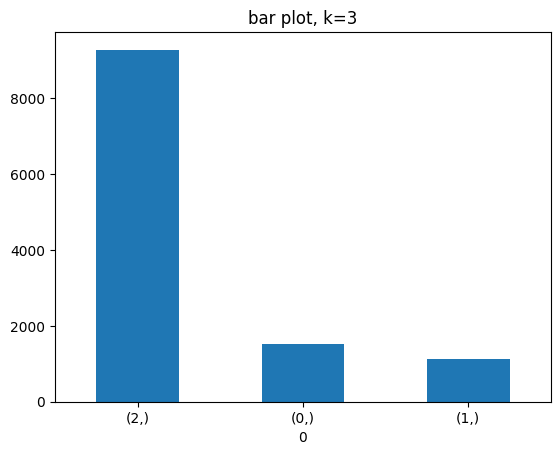

In [52]:
# TODO: Enter code here to produce a bar plot of the cluster size
# import matplotlib.pyplot as plt
# y = (len(kmeans.labels_[kmeans.labels_==0]),len(kmeans.labels_[kmeans.labels_==1]),len(kmeans.labels_[kmeans.labels_==2]))
# plt.bar((0,1,2),y)
# plt.xlabel("Cluster", labelpad=14)
# plt.ylabel("Numbers", labelpad=14)
import matplotlib.pyplot as plt

pd.DataFrame(kmeans.labels_).value_counts().plot(kind='bar', rot=0, title='bar plot, k=3')


Note that sizes may vary considerable between clusters and among different random seeds.

## Problem 2: Summarize clusters

Once you have a clustering, you can try to see whether it is meaningful. One useful technique in that context is to generate a **summary** for each cluster by extracting the $n$ highest-weighted terms from the centroid of each cluster. Your next task is to implement this approach.

**Hint:** You will need to construct an &lsquo;inverted vocabulary&rsquo; that allows you to map from the index of a term back to the original term.

In [53]:
# TODO: Enter code here to compute the cluster summaries and print them
n_highest_terms = 10
centroids = kmeans.cluster_centers_
vocabulary = vectorizer.get_feature_names_out()

k = n_class # k = 3
for i in range(k):
    # get index of highest-weighted terms
    index = centroids[i].argsort()[::-1][:n_highest_terms]
    # get words from vocabulary
    terms = [vocabulary[i] for i in index]
    print(f'cluster: {i}, highest-weighted terms: {terms}')


cluster: 0, highest-weighted terms: ['book', 'quot', 'read', 'books', 'author', 'reading', 'story', 'like', 'just', 'good']
cluster: 1, highest-weighted terms: ['camera', 'lens', 'pictures', 'canon', 'digital', 'use', 'battery', 'flash', 'quality', 'great']
cluster: 2, highest-weighted terms: ['like', 'product', 'movie', 'great', 'just', 'good', 'cd', 'use', 'time', 'album']


Once you have computed the cluster summaries, take a minute to reflect on their quality. Is it clear what the reviews in a given cluster are about? Do the cluster summaries contain any unexpected terms?

## Problem 3: Compare clusterings using the Rand index

In some scenarios, you may have gold-standard class labels available for at least a subset of your documents. In these cases you can compute the **Rand index** of a clustering, and use this measure to compare the quality of different clusterings.

To compute the Rand index, we view a clustering as a binary classifier on (unordered) pairs of documents. The classifier predicts &lsquo;positive&rsquo; if and only if the two documents belong to the same cluster. The (non-normalized) Rand index of the clustering is the accuracy of this classifier relative to a reference in which a document pair belongs to the &lsquo;positive&rsquo; class if and only if the two documents in the pair have the same gold-standard class label. You are supposed to implement the procedure yourselves, not import an external function.

Compare clusterings with $k \in \{1,3,5,7\}$ clusters. As your evaluation data, use the first 500 documents from the original data set along with their gold-standard categories (from the `category` column).

In [54]:
# TODO: Enter code here to (manually) compute the Rand indices for the two clusterings
import itertools


x = reviews[0:500, :]
standard = df['category'][0:500]
k_values = [1, 3, 5, 7,8,9,10] # Here we test more k_values to get elbow method result
accuracy_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=6).fit(x)
    labels = kmeans.labels_

    pairs = list(itertools.combinations(range(500), 2))
    sum_ = sum([1 for x in pairs if (labels[x[0]]==labels[x[1]] and standard[x[0]]==standard[x[1]]) or (labels[x[0]]!=labels[x[1]] and standard[x[0]]!=standard[x[1]])])
    accuracy = sum_/(500*499/2)
    print(f'number of cluster: {k}, rand index: {accuracy}')
    accuracy_values.append(accuracy)


number of cluster: 1, rand index: 0.16626052104208416
number of cluster: 3, rand index: 0.6059959919839679
number of cluster: 5, rand index: 0.7160320641282565
number of cluster: 7, rand index: 0.788689378757515
number of cluster: 8, rand index: 0.7812264529058116
number of cluster: 9, rand index: 0.8245691382765531
number of cluster: 10, rand index: 0.8188456913827655


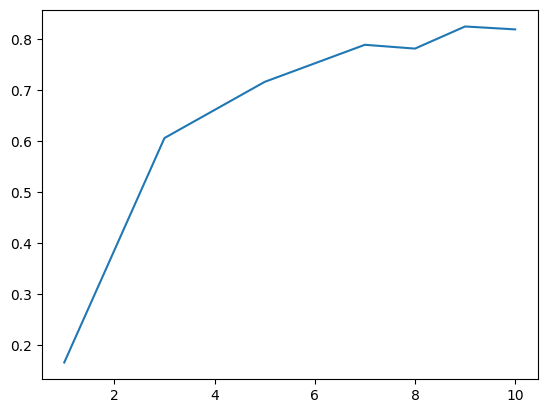

In [55]:
plt.plot(k_values, accuracy_values)

*TODO: Insert a summary of your results here*

## Topic modelling data set

The data set for the topic modelling part of this lab is the collection of all [State of the Union](https://en.wikipedia.org/wiki/State_of_the_Union) addresses from the years 1975–2000. These speeches come as a single text file with one sentence per line. The following code cell prints the first 5 lines from the data file:

In [56]:
with open('sotu_1975_2000.txt') as source:
    for i, line in enumerate(source):
        print(line.rstrip())
        if i >= 5:
            break

mr speaker mr vice president members of the 94th congress and distinguished guests
twenty six years ago a freshman congressman a young fellow with lots of idealism who was out to change the world stood before sam rayburn in the well of the house and solemnly swore to the same oath that all of you took yesterday an unforgettable experience and i congratulate you all
two days later that same freshman stood at the back of this great chamber over there someplace as president truman all charged up by his single handed election victory reported as the constitution requires on the state of the union
when the bipartisan applause stopped president truman said i am happy to report to this 81st congress that the state of the union is good our nation is better able than ever before to meet the needs of the american people and to give them their fair chance in the pursuit of happiness it is foremost among the nations of the world in the search for peace
today that freshman member from michigan stan

Take a few minutes to think about what topics you would expect in this data set.

## Problem 4: Train a topic model

Your first task on the topic modelling data is to train an LDA model. For this task you will be using [spaCy](https://spacy.io/) and the [gensim](https://radimrehurek.com/gensim/) topic modelling library.

Start by preprocessing the data using spaCy. Given that the data set for this problem is rather small, you do not have to exclude any components from the standard pipeline. Filter out stop words, non-alphabetic tokens, and tokens less than 3 characters in length. Store the documents as a nested list where the first level of nesting corresponds to the sentences and the second level corresponds to the tokens in each sentence.

In [57]:
# TODO: Replace the following lines with your own code for preprocessing the documents
from spacy.tokens import Doc
import spacy

with open('sotu_1975_2000.txt') as source:
    text = [line.split() for line in source]
    
    nlp = spacy.load('en_core_web_sm')
    documents = []
    for line in text:
        doc=Doc(nlp.vocab,line)
        line_token=[]
        for x in nlp(doc):
            if x.is_stop==False and x.is_alpha==True and len(x)>=3:
                line_token.append(str(x))
        documents.append(line_token)
    

Test your preprocessing by running the following cell:

In [58]:
' '.join(documents[42])

'reduce oil imports million barrels day end year million barrels day end'

You should get the following output:

Once you have the list of documents, skim the section [Pre-process and vectorize the documents](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents) of the gensim documentation to learn how to create the dictionary and the vectorized corpus representation required by gensim. (Note that you cannot use the standard scikit-learn pipeline in this case.) Then, write code to train an [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) for $k=10$ topics, and using default values for all other parameters.

In [59]:
# TODO: Enter code here to train an LDA model and store it in a variable `model`

from gensim.corpora.dictionary import Dictionary
import gensim.models.ldamodel

dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

model = LdaModel(corpus, num_topics=10,id2word=dictionary)

Once you have a trained model, run the following cell to print the topics:

In [60]:
from pprint import pprint
pprint(model.show_topics())

[(0,
  '0.026*"children" + 0.014*"parents" + 0.013*"schools" + 0.010*"work" + '
  '0.008*"teachers" + 0.007*"congress" + 0.007*"people" + 0.007*"child" + '
  '0.006*"years" + 0.006*"school"'),
 (1,
  '0.009*"work" + 0.008*"new" + 0.007*"years" + 0.007*"americans" + '
  '0.006*"care" + 0.006*"american" + 0.006*"people" + 0.006*"working" + '
  '0.006*"congress" + 0.005*"rights"'),
 (2,
  '0.015*"new" + 0.009*"budget" + 0.007*"years" + 0.006*"america" + '
  '0.006*"cancer" + 0.006*"welfare" + 0.006*"covenant" + 0.005*"child" + '
  '0.005*"year" + 0.005*"american"'),
 (3,
  '0.013*"year" + 0.011*"people" + 0.011*"let" + 0.011*"work" + '
  '0.010*"welfare" + 0.008*"health" + 0.008*"government" + 0.007*"pass" + '
  '0.007*"budget" + 0.007*"care"'),
 (4,
  '0.012*"new" + 0.010*"americans" + 0.007*"america" + 0.007*"american" + '
  '0.007*"government" + 0.005*"congress" + 0.005*"people" + 0.005*"help" + '
  '0.005*"nation" + 0.005*"programs"'),
 (5,
  '0.015*"america" + 0.013*"people" + 0.009*

Inspect the topics. Can you &lsquo;label&rsquo; each topic with a short description of what it is about? Do the topics match your expectations?

## Problem 5: Monitor a topic model for convergence

When learning an LDA model, it is important to make sure that the training algorithm has converged to a stable posterior distribution. One way to do so is to plot, after each training epochs (or &lsquo;pass&rsquo;, in gensim parlance) the log likelihood of the training data under the posterior. Your last task in this lab is to create such a plot and, based on this, to suggest an appropriate number of epochs.

To collect information about the posterior likelihood after each pass, we need to enable the logging facilities of gensim. Once this is done, gensim will add various diagnostics to a log file `gensim.log`.

In [61]:
import logging

logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

The following function will parse the generated logfile and return the list of log likelihoods.

In [62]:
import re

def parse_logfile():
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

Your task now is to re-train your LDA model for 50&nbsp;passes, retrieve the list of log likelihoods, and create a plot from this data.

In [63]:
# TODO: Enter code here to generate the convergence plot
model = LdaModel(corpus, num_topics=10,id2word=dictionary,passes=50)
loglike = parse_logfile()

Text(0, 0.5, 'loglikelihood')

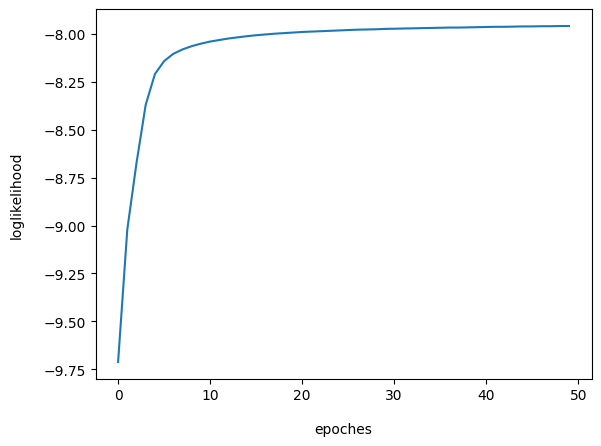

In [64]:
log = loglike[(len(loglike)-50):]
plt.plot(range(len(log)),log)
plt.xlabel("epoches", labelpad=14)
plt.ylabel("loglikelihood", labelpad=14)

How do you interpret your plot? Based on the plot, what would be a reasonable choice for the number of passes? Retrain your LDA model with that number and re-inspect the topics it finds. Do you consider the new topics to be &lsquo;better&rsquo; than the ones that you got from the 1-pass model in Problem&nbsp;4?

**From the plot above, we can see the loglikelihood kept increasing at first and after 5 epoches it remained at a steady level. So 5 epoches are reasonable for the model.**

In [65]:
# retrain the model
model = LdaModel(corpus, num_topics=10,id2word=dictionary,passes=5)

pprint(model.show_topics())

[(0,
  '0.015*"government" + 0.008*"federal" + 0.006*"education" + 0.006*"row" + '
  '0.006*"tobacco" + 0.006*"america" + 0.005*"tuition" + 0.005*"need" + '
  '0.005*"president" + 0.005*"college"'),
 (1,
  '0.024*"new" + 0.016*"america" + 0.013*"schools" + 0.011*"people" + '
  '0.010*"school" + 0.010*"americans" + 0.008*"teachers" + 0.008*"year" + '
  '0.008*"help" + 0.007*"work"'),
 (2,
  '0.022*"world" + 0.016*"union" + 0.014*"america" + 0.012*"american" + '
  '0.010*"nation" + 0.010*"soviet" + 0.010*"people" + 0.008*"freedom" + '
  '0.008*"state" + 0.008*"years"'),
 (3,
  '0.013*"let" + 0.013*"new" + 0.010*"community" + 0.009*"people" + '
  '0.009*"america" + 0.008*"americans" + 0.007*"year" + 0.007*"american" + '
  '0.007*"way" + 0.007*"security"'),
 (4,
  '0.012*"world" + 0.012*"america" + 0.010*"states" + 0.009*"united" + '
  '0.007*"trade" + 0.007*"nations" + 0.006*"defense" + 0.006*"nation" + '
  '0.006*"peace" + 0.006*"countries"'),
 (5,
  '0.017*"years" + 0.014*"people" + 0.0

The new topics are better because compared to the 1 pass model the probabilities of each topic increased.

## Reflection questions

The following reflection questions will help you prepare for the diagnostic test. Answer each of them in the form of a short text and put your answers in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 3.1:** Based on your experiments in Problem&nbsp;2 and Problem&nbsp;3, what is the relation between the quality of a clustering and the number of clusters? What happens when the number of clusters is too low, or too high? For this particular data set, what would a &lsquo;good&rsquo; number of clusters be?

**RQ 3.2:** Explain why it is important to monitor an LDA model for convergence and not simply use, say, 1000&nbsp;passes. How is the log likelihood used in this context? Were the topics from the multi-pass model &lsquo;better&rsquo; than the topics from the 1-pass model?

**RQ 3.3:** What are the differences between $k$-means and LDA? When would you use one, when the other?

*TODO: Enter your answers here*

**3.1**

The relationship between the number of clusters and the quality of the model is a very subjective issue. We know that SSE tends to 0 as the number of clusters increases, but we only select the size of the cluster and the quality of the model based on SSE. This is a process of trade-offs.

When the number of clusters is too small, the effect of classification cannot be achieved. Too many clusters, which is a waste (think too many outliers with their own clusters).

"The Rand index of a clustering measures the accuracy of this classiﬁer relative to the gold-standard class assignment."
According to elbow method, the best K value here is 5.

**3.2**

There is a stationary distribution for LDA, and the convergence is monitored to obtain this stationary model. If the experiment fails to converge, it may be that the calculation time is not long enough or the number of topics set is too large.

In order to simplify the calculation, we usually take the logarithm of the likelihood function (without affecting its monotonicity), and transform it into a maximum likelihood estimation problem.

Multi-pass models are not always on topic better than 1-pass models.

**3.3**

K-means is a Hard clustering method, LDA is a Soft clustering method.

When we want each document either belongs to a cluster or not, we use K-means;

When we want each document belongs to each cluster to a certain degree, we use LDA;

**Congratulations on finishing L3! 👍**